# 'Surprising alpha'

&copy; **Johannes Ruf** (comments welcome under j.ruf@lse.ac.uk, February 2023)

In [30]:
import pandas as pd
import numpy as np
import statsmodels.api
import scipy

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

DATAPATH = '~/Desktop/YOUR_FOLDER_NAME/'

This notebook is based on this [paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3522675). 
(Joint work with Adrian Banner, Bob Robert Fernholz, Vassilios Papathanakos, David Schofield). 

Here we use a longer time series than in the paper. The paper is based on daily data, but monthly data yield very similar results.

Suppose we wish to calculate the average annual return of an investment over several years, where the annual returns are given by $r_1,r_2,\ldots,r_n$. 

Several common methods are available, for example:
* *Arithmetic return*: $\frac{1}{n}\Big((1+r_1)+\cdots+(1+r_n)\Big)-1$. 
* *Logarithmic return*: $\frac{1}{n}\Big(\log(1+r_1)+\cdots+\log(1+r_n)\Big)$.

*Jensen's inequality* yields

$$
\text{ arithmetic return } \ge \text{ logarithmic return}.
$$

**The dynamics of return**

* Simple mathematical model: Let $S(t)$ represent the price of an investment at time $t$ and assume that

$$
d S(t) = S(t) \left[ b(t) d t + \sigma(t) d W(t)\right].
$$

* Then $b$ is called the *rate of return* of $S$.

* Ito's formula implies that

$$
d \log S(t) =  g(t) d t + \sigma(t) d W(t),
$$

where

$$
 g(t)=b(t)-\frac{1}{2} \sigma^2(t).
$$

* $g$ is called the *rate of log-return*, or *growth rate*, of $S$.


* The process $g$ determines the long-term behavior of $S$:

$$
\lim_{T \uparrow \infty} \frac{1}{T} \Big( \log S(T)- \int_0^T g(t)d t \Big)=0
$$

(under appropriate assumptions).


**Portfolio return and log-return**


* Suppose we have assets $S_1,\ldots,S_d$ and a portfolio $\pi$ with  weights $\pi_1(t)+\cdots+\pi_d(t)=1$ and value $V^\pi(t)$ at time $t$. 

* *Markowitz (1952)*: The portfolio return satisfies

$$
\frac{d V^\pi(t)}{V^\pi(t)}= \sum_{i=1}^d \pi_i(t)\,\frac{d S_i(t)}{S_i(t)}.
$$

* *Fernholz and Shay (1982)*: The analogous equation for the log-return is

$$
d \log V^\pi(t) =\sum_{i=1}^d \pi_i(t) d \log S_i(t) + \color{red}{\gamma^*_\pi(t) d t},
$$

where $\gamma^*_\pi \geq 0$, provided the portfolio is long-only.

* $\gamma^*_\pi$ depends only on the covariance structure of $S$ and can be expressed as

$$
\gamma^*_\pi(t)=\frac{1}{2}\Big(\sum_{i=1}^d \pi_i(t) \sigma^2_i(t) -  \sigma^2_\pi(t)\Big).
$$

**Summary: Decomposition of portfolio log-return**

\begin{align*}
\text{Log-return} &=\int_{0}^{T} \sum_{i=1}^d \pi_i(t) d \log S_i(t)+ \int_{0}^{T}  \gamma^*_\pi(t) d t\\
	&=: A_\pi(T) + \Gamma_\pi(T).
\end{align*}

**Outline**  

* We will look closer at returns versus log-returns. The key idea is to consider (log-)returns by rank, and not by name. To this end, let $r_t(i)$ be the rank of $S_i(t)$. Define the *average rank-based growth rates* ${\bf g}_k$ by

$$
{\bf g}_k = \frac{1}{T} \int_{0}^{T}\sum \mathbb{1}_{\{r_t(i)=k\}} d \log S_i(t).
$$

* We will look closer at the decomposition of log-returns for a variety of portfolios.

### Loading and preparing the data

We have risk-free rates from the Fed from middle of June 1961 (see below). We also want to look at the top 1000 stocks, and CRSP has roughly 1000 securities (or more) from around this date onwards.

In [2]:
start_date = '1961-07'

with pd.HDFStore(DATAPATH + 'CRSP_monthly.h5') as store:
    df = store['df'].loc[start_date:'2022-12']
    
df['mthret'].shape

(738, 22353)

Uncommenting the following two cells removes all the returns that were flagged in the cleaning process (e.g., missing delisting returns or returns based on bid/ask spreads). Running the notebook with these returns removed can be used for a robustness analysis -- do the results differ without these returns? How much do those returns matter?

In [3]:
#df['mthprevcap'] = df['mthprevcap'].mask(df['bcktstflg'].gt(0))
#df['mthret'] = df['mthret'].mask(df['bcktstflg'].gt(0))

The portfolios below will only look at portfolios that invest in the top `d` stocks at the time of investment.

In [4]:
d = 1000    # size of investment universe

In [5]:
# removing all the stocks that are never among the top 1000  
# This step is mandatory but removes unncesary colummns, which speeds up the code 
# (especially when daily returns are used -- not in this notebook)

ranks = df['mthprevcap'].rank(axis=1, ascending=False, method='first')
at_least_once_top_d = ranks.columns[ranks.min() <= d]
df = df.loc[:, df.columns.get_level_values('permno').isin(at_least_once_top_d)]
df['mthret'].shape

(738, 6404)

The previous cleaning step was not really necessary; however, especially when working with daily data such a step helps to reduce the size of data significantly. Important warning: The investment universe we created is **not survivorship-bias free** anymore. (Why not??)  

For our analysis, below, we are **not exposed to this survivorship bias**. Indeed, the strategies below only invest in stocks that are at the time of investment among the top `d` stocks; the strategies do not invest in stocks for which we wouldn't know yet (at the time of the investment) whether the stock is included in the investment universe or not. 

The following code returns the one-year holding period return for each stock:

In [6]:
rets_index = df['mthret'].add(1).cumprod().fillna(method='ffill')
rets_1y = rets_index.shift(-11).divide(rets_index.shift(1).fillna(1)).subtract(1).mask(df['mthret'].isnull())
# the August 1970 entry for example corresponds to the period from the beginning of August to the end of July 1971

del rets_index

We plan to do a rank-based analysis. The following recode orders the data in a useful way. It puts the market capitalizations and the returns of the largest company (at that point of time) in the first column, the market capitalizations and the returns of the second-largest company in the second column, etc.

In [7]:
type(-df['mthprevcap'].values)

numpy.ndarray

In [8]:
idx = (-df['mthprevcap'].values).argsort()

caps_ranked = pd.DataFrame(df['mthprevcap'].values[np.arange(len(idx)), idx.T].T[:, :d], 
                           index=df.index, columns=range(1, d + 1))

rets_ranked = pd.DataFrame(df['mthret'].values[np.arange(len(idx)), idx.T].T[:, :d], 
                           index=df.index, columns=range(1, d + 1))

rets_1y_ranked = pd.DataFrame(rets_1y.values[np.arange(len(idx)), idx.T].T[:, :d], 
                           index=rets_1y.index, columns=range(1, d + 1))

bcktstflg_ranked = pd.DataFrame(df['bcktstflg'].values[np.arange(len(idx)), idx.T].T[:, :d], 
                           index=df.index, columns=range(1, d + 1))

del idx

Let's now look briefly look at how many returns were flagged in the cleaning process:

In [9]:
bcktstflg_ranked.stack().value_counts(normalize=True)

0.0     0.991228
1.0     0.005108
2.0     0.002507
10.0    0.000911
4.0     0.000213
12.0    0.000018
14.0    0.000009
3.0     0.000007
dtype: float64

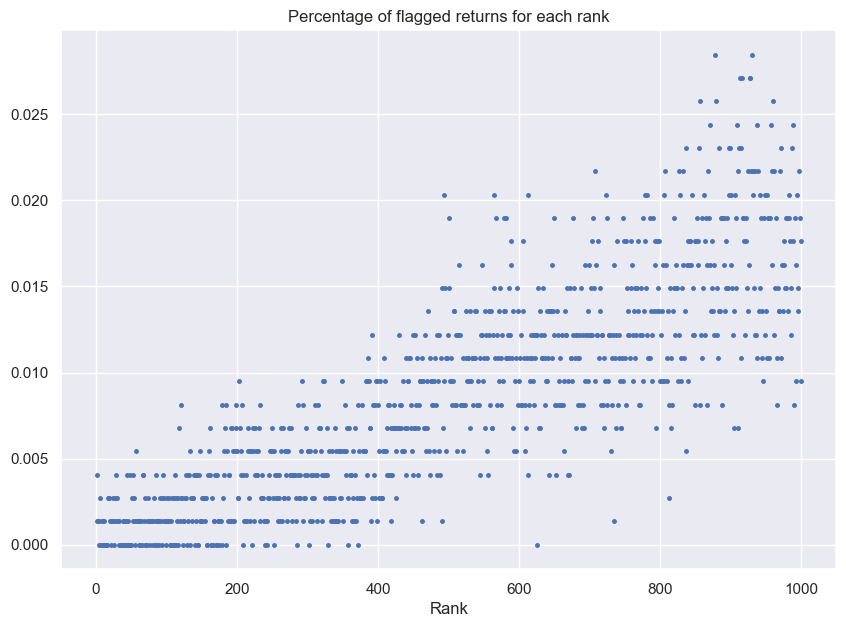

In [10]:
ax = bcktstflg_ranked.gt(0).sum().divide(len(bcktstflg_ranked)).plot(figsize=(10, 7), style='o', markersize=2.5)
ax.set_title('Percentage of flagged returns for each rank');
ax.set_xlabel('Rank');

Below, we will also rely on the covariance matrix when analyzing the portfolio performance (more precisely, when computing the term $\Gamma_\pi$ in the log-return decomposition.)

In [11]:
ret_cov = rets_ranked.cov().multiply(12)

We perform one more step of data cleaning. Since we are interested in logarithmic returns, returns of -1 will be problematic. We replace such returns by -0.95 (i.e., we assume a recovery of at least 5%). Changing this number is useful for a robustness analysis.

In [12]:
LOWER_BOUND = -0.95   #lower bound for returns when computing log returns

In [13]:
print('Lower bound on returns not satisfied: {}'.format(rets_ranked.lt(LOWER_BOUND).sum().sum()))

Lower bound on returns not satisfied: 9


In [14]:
rets_ranked = rets_ranked.mask(rets_ranked.lt(LOWER_BOUND), LOWER_BOUND)

### Rank-based analysis of returns

At this point, we don't yet look at portfolios, but focus on some descriptive statistics of the 'ranked returns'.

In [15]:
stats_ranks = np.log(rets_ranked.add(1)).mean().multiply(12).to_frame().rename(columns={0: 'Mean log-return'})
# our g_k's from above

stats_ranks['Mean arithmetic return'] = rets_ranked.mean() * 12

stats_ranks['Sample variance log-return'] = np.log(rets_ranked.add(1)).var() * 12
stats_ranks['Sample variance arithmetic return'] = rets_ranked.var() * 12

stats_ranks['Sample variance log-return smoothed'] = statsmodels.nonparametric.smoothers_lowess.lowess(
    stats_ranks['Sample variance log-return'], stats_ranks.index, frac = 0.1)[:,1]
stats_ranks['Sample variance arithmetic return smoothed'] = statsmodels.nonparametric.smoothers_lowess.lowess(
    stats_ranks['Sample variance arithmetic return'], stats_ranks.index, frac = 0.1)[:,1]

stats_ranks['Discretization error'] = stats_ranks['Mean arithmetic return'] - \
                        stats_ranks['Sample variance arithmetic return'] / 2 - stats_ranks['Mean log-return']

stats_ranks['Rank'] = stats_ranks.index

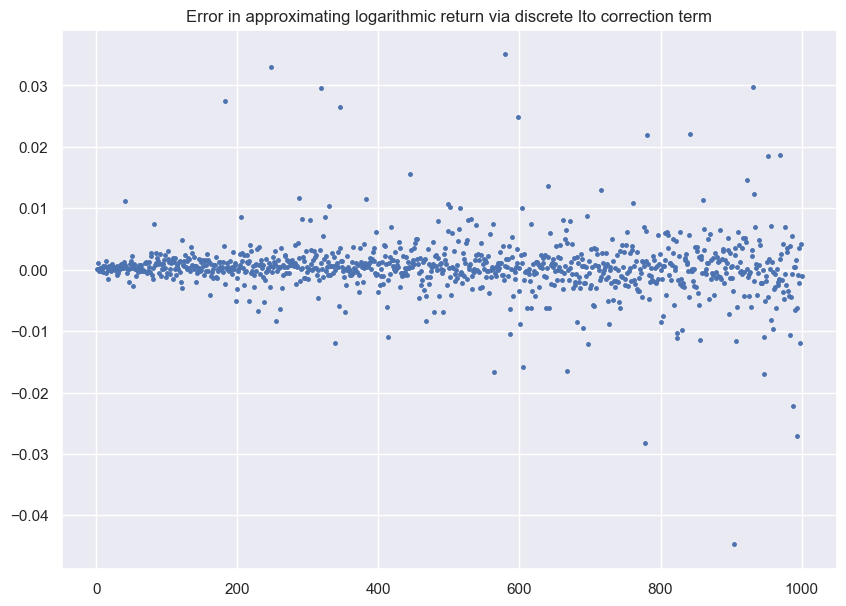

In [16]:
ax = stats_ranks['Discretization error'].plot(style='o', markersize=2.5, figsize=(10, 7))
ax.set_title('Error in approximating logarithmic return via discrete Ito correction term');

Slope of regression line (log-returns):		-0.0000283 +/- 2 * 0.0000043.
Slope of regression line (arithmetic returns):	 0.0000255 +/- 2 * 0.0000043.


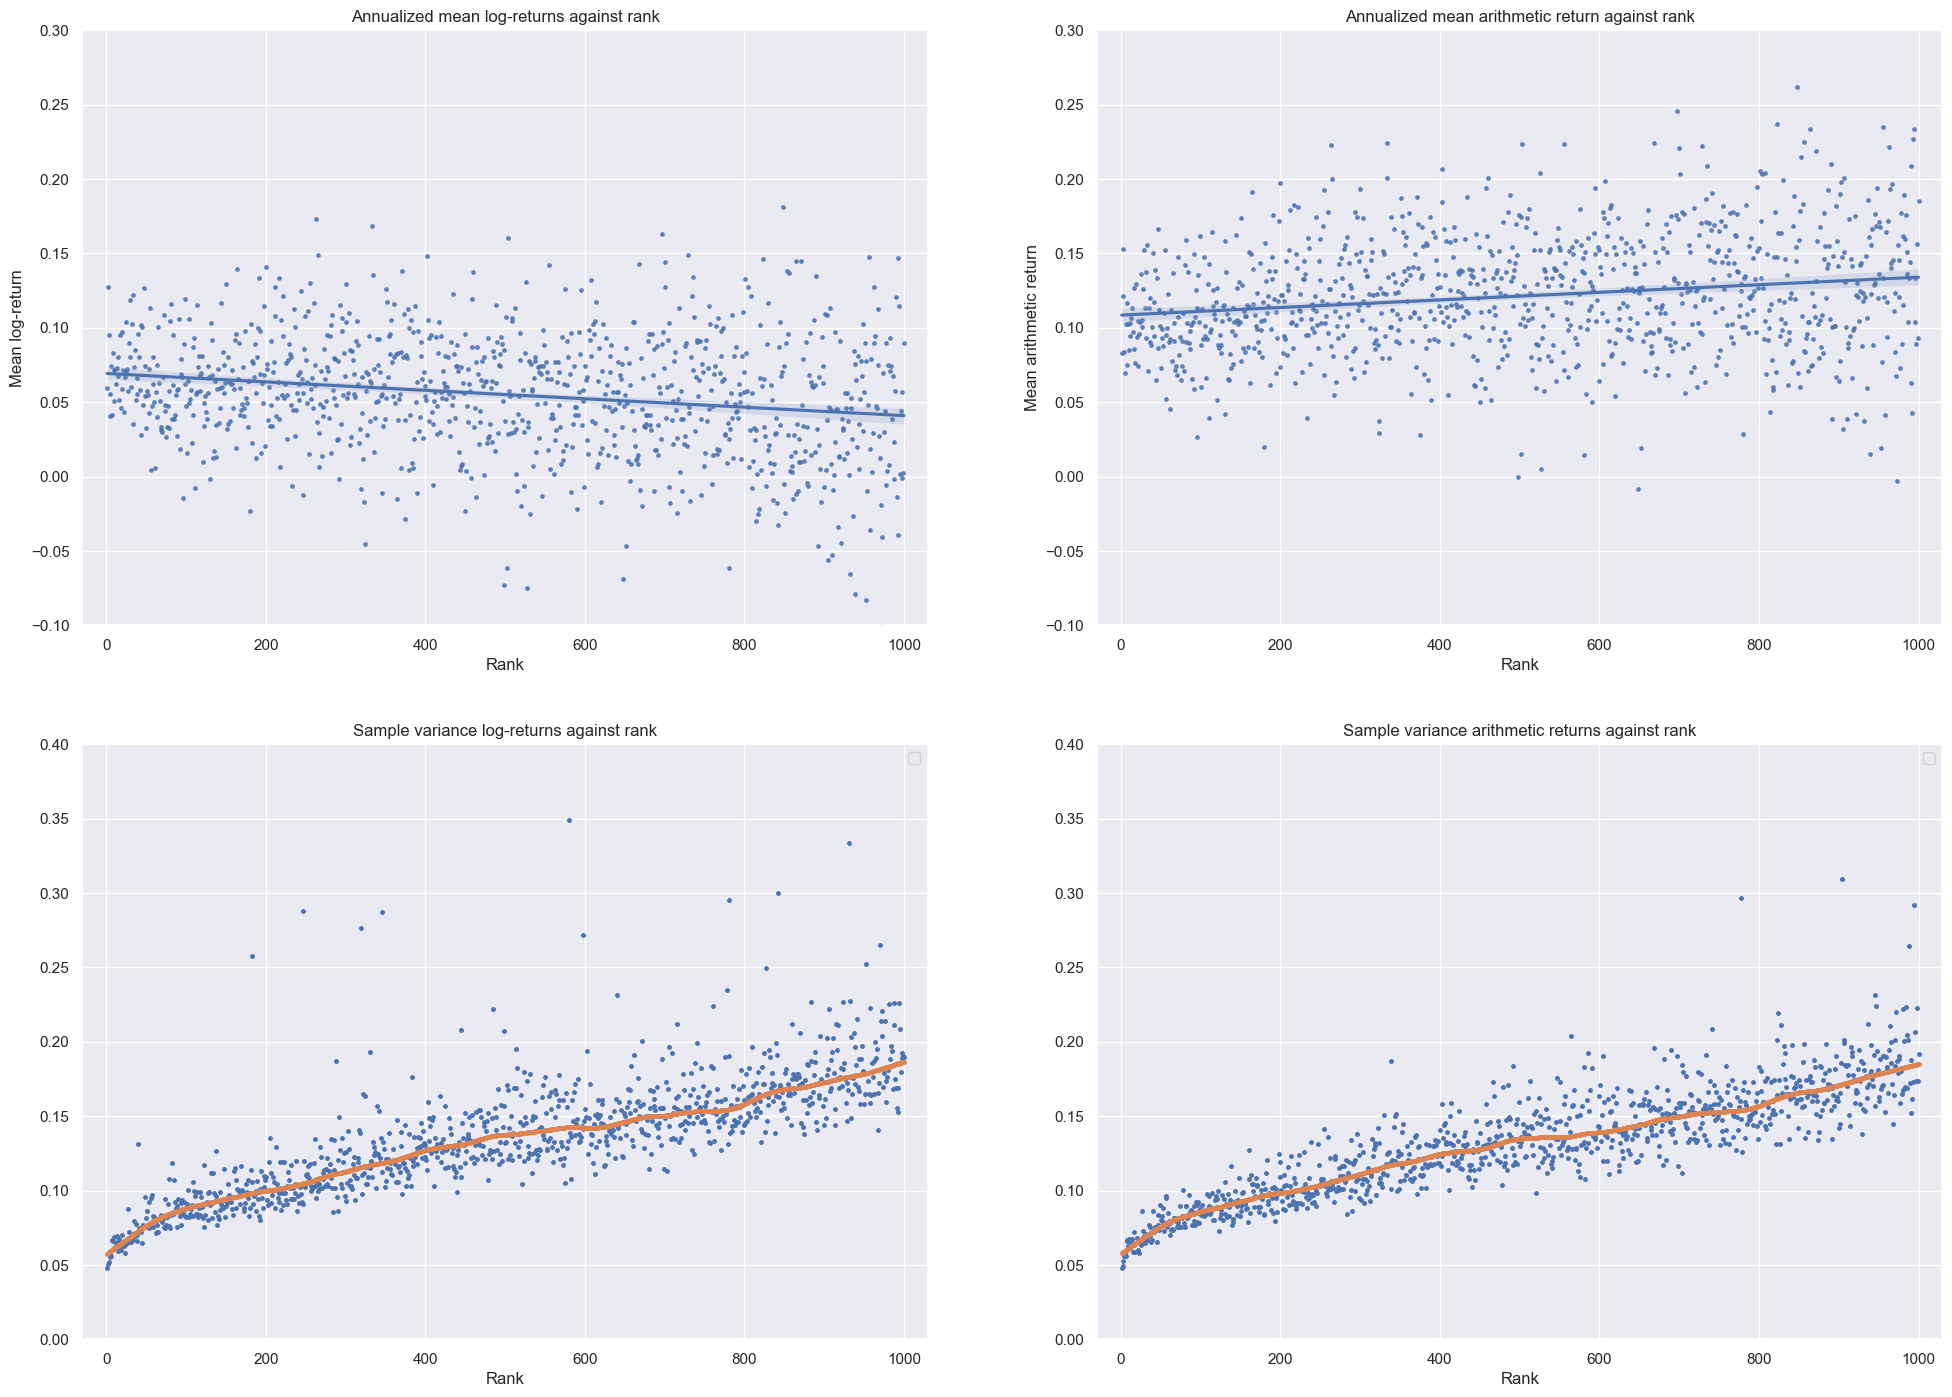

In [17]:
_, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2, figsize=(24,17))  

sns.regplot(x='Rank', y='Mean log-return', data=stats_ranks, scatter_kws={'s':6}, ax=ax1)
ax1.set_title("Annualized mean log-returns against rank")

sns.regplot(x='Rank', y='Mean arithmetic return', data=stats_ranks, scatter_kws={'s':6}, ax=ax2)
ax2.set_title("Annualized mean arithmetic return against rank")

for ax in [ax1, ax2]:
    ax.set_ylim([-0.10, 0.3]);     # optimized for d = 1000
    ax.set_xlim([-0.03 * d, 1.03 * d]);
    
stats_ranks[['Sample variance log-return', 'Sample variance log-return smoothed']].plot(
    style='o', markersize=2.5, ax=ax3)
ax3.set_title("Sample variance log-returns against rank")

stats_ranks[['Sample variance arithmetic return', 'Sample variance arithmetic return smoothed']].plot(
    style='o', markersize=2.5, ax=ax4)
ax4.set_title("Sample variance arithmetic returns against rank")

for ax in [ax3, ax4]:
    ax.set_ylim([0, 0.4]);
    ax.set_xlim([-0.03 * d, 1.03 * d]);
    ax.legend('')
    ax.set_xlabel('Rank')

sslope, _, _, _, sstd = scipy.stats.linregress(x=stats_ranks['Rank'], y=stats_ranks['Mean log-return'])
print(f'Slope of regression line (log-returns):\t\t{sslope: .7f} +/- 2 *{sstd: .7f}.')
sslope, _, _, _, sstd = scipy.stats.linregress(x=stats_ranks['Rank'], y=stats_ranks['Mean arithmetic return'])
print(f'Slope of regression line (arithmetic returns):\t{sslope: .7f} +/- 2 *{sstd: .7f}.')

We see: for log-returns if anything then smaller stocks have a lower log-return. Arithmetic returns for smaller stocks are larger because they have a higher variance. The higher the variance the more upwards biased is the arithmetic return as a measurement for long-term growth of an investment.

### A portfolio analysis

#### Including risk-free rates

To compute Sharpe ratios, we use risk-free rates ('one-year zero-coupon yields, continuously compounded) from the [Fed](https://www.federalreserve.gov/data/nominal-yield-curve.htm). They are stored in the following csv file.

In [18]:
file_fed_rates = 'feds200628.csv'

In [19]:
rf = pd.read_csv(DATAPATH + file_fed_rates, skiprows=7, header=1, parse_dates=['Date'])
rf = rf[['Date', 'SVENY01']].rename(columns={'Date': 'date'}).set_index('date').dropna()

In [20]:
rf.head()

,SVENY01
date,
1961-06-14,2.9825
1961-06-15,2.9941
1961-06-16,3.0012
1961-06-19,2.9949
1961-06-20,2.9833


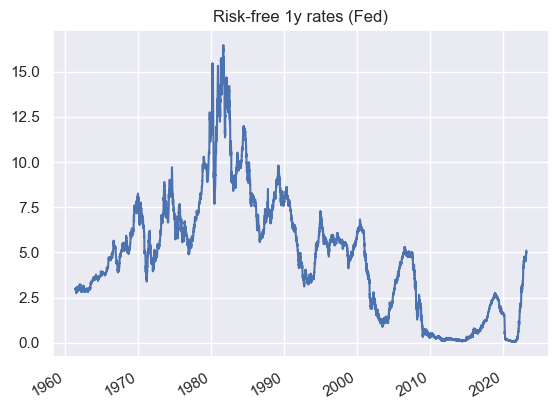

In [21]:
ax = rf.plot(title='Risk-free 1y rates (Fed)', legend='');
ax.set_xlabel('');

In [22]:
rf = rf.resample('1M').last()[:'2022-11']

rf.index = rets_1y_ranked.index     
# shifts index by one month (idee: investment starting in July 1970 (indexed end-of-July in rets_1y_ranked) 
# should have rates from end of June 1969, etc)

In [23]:
if 'SVENY01' in rf:
    rf['1Y_riskfree_ret'] = np.exp(rf['SVENY01'] / 100) - 1
    rf = rf.drop('SVENY01', axis=1)
rf = rf.squeeze()

#### A function to summarize important portfolio characteristics

The next function takes a portfolio (possibly not normalized to 1) and prints several summary statistics.

In [24]:
def portfolio_log_returns(π, r, rf, r_cov):
    π = π.div(π.sum(axis=1), axis=0)   #normalize
    
    arit_rets = π.multiply(r).sum(axis=1)  
    arit_rets_jan = arit_rets.groupby(arit_rets.index.year).first().iloc[1:]
    # non-overlapping intervals, starting in Jan

    excess_rets = arit_rets - rf
    excess_rets_jan = excess_rets.groupby(excess_rets.index.year).first().iloc[1:]
    
    log_rets = np.log(arit_rets.add(1))
    log_rets_jan = log_rets.groupby(log_rets.index.year).first().iloc[1:]     

    A_pi = π.multiply(np.log(r.mask(r.lt(LOWER_BOUND), LOWER_BOUND).add(1))).sum(axis=1).mean()
    Gamma_pi = (π.dot(np.diag(r_cov)) - ((π @ r_cov) * π).sum(axis=1)).mean() / 2
 
    Sharpe_ratio = excess_rets.mean() / excess_rets.std()
    Sharpe_ratio_arit = excess_rets.mean() / arit_rets.std()   
    
    Sharpe_ratio_jan = excess_rets_jan.mean() / excess_rets_jan.std()    
    Sharpe_ratio_arit_jan  = excess_rets_jan.mean() / arit_rets_jan.std()  
    
    
    print('Mean log-return, overlapping intervals: \t\t\t{:.2f}'.format(log_rets.mean()))
    print('Mean log-return, yearly intervals, starting in January:\t\t{:.2f}'.format(log_rets_jan.mean()))  
    print('Std log return, overlapping intervals: \t\t\t\t{:.2f}'.format(log_rets.std()))
    print('Std log return, yearly intervals, starting in January: \t\t{:.2f}\n'.format(log_rets_jan.std()))

    print('Mean arith. return, overlapping intervals: \t\t\t{:.2f}'.format(arit_rets.mean()))
    print('Mean arith. return, yearly intervals, starting in January: \t{:.2f}'.format(arit_rets_jan.mean()))
    print('Std arith. return, overlapping intervals: \t\t\t{:.2f}'.format(arit_rets.std()))
    print('Std arith. return, yearly intervals, starting in January: \t{:.2f}\n'.format(arit_rets_jan.std()))

    print('Std excess return, overlapping intervals: \t\t\t{:.2f}'.format(excess_rets.std()))
    print('Std excess return, yearly intervals, starting in January: \t{:.2f}\n'.format(excess_rets_jan.std()))

    print('Overlapping intervals, estimate for A:\t\t\t\t{:.2f}'.format(A_pi))
    print('Overlapping intervals, estimate for Gamma:\t\t\t{:.2f}'.format(Gamma_pi))    
    print('Sum of A and Gamma:\t\t\t\t\t\t{:.2f}\n'.format(A_pi + Gamma_pi))       
       
    print('Sharpe ratio (arith.), overlapping intervals: \t\t\t{:.2f}'.format(Sharpe_ratio_arit))
    print('Sharpe ratio, overlapping intervals: \t\t\t\t{:.2f}'.format(Sharpe_ratio))
    print('Sharpe ratio (arith.), yearly intervals, starting in January: \t{:.2f}'.format(Sharpe_ratio_jan))
    print('Sharpe ratio, yearly intervals, starting in January: \t\t{:.2f}'.format(Sharpe_ratio_arit_jan))

#### Different portfolios

##### Capitalization-weighted

In [25]:
portfolio_log_returns(caps_ranked, rets_1y_ranked, rf, ret_cov)

Mean log-return, overlapping intervals: 			0.10
Mean log-return, yearly intervals, starting in January:		0.09
Std log return, overlapping intervals: 				0.16
Std log return, yearly intervals, starting in January: 		0.17

Mean arith. return, overlapping intervals: 			0.11
Mean arith. return, yearly intervals, starting in January: 	0.11
Std arith. return, overlapping intervals: 			0.16
Std arith. return, yearly intervals, starting in January: 	0.17

Std excess return, overlapping intervals: 			0.17
Std excess return, yearly intervals, starting in January: 	0.17

Overlapping intervals, estimate for A:				0.06
Overlapping intervals, estimate for Gamma:			0.03
Sum of A and Gamma:						0.10

Sharpe ratio (arith.), overlapping intervals: 			0.39
Sharpe ratio, overlapping intervals: 				0.38
Sharpe ratio (arith.), yearly intervals, starting in January: 	0.37
Sharpe ratio, yearly intervals, starting in January: 		0.37


##### Equally weighted

In [26]:
π = pd.DataFrame(1, index=rets_1y_ranked.index, columns=rets_1y_ranked.columns)
portfolio_log_returns(π, rets_1y_ranked, rf, ret_cov)

Mean log-return, overlapping intervals: 			0.11
Mean log-return, yearly intervals, starting in January:		0.11
Std log return, overlapping intervals: 				0.17
Std log return, yearly intervals, starting in January: 		0.18

Mean arith. return, overlapping intervals: 			0.13
Mean arith. return, yearly intervals, starting in January: 	0.13
Std arith. return, overlapping intervals: 			0.19
Std arith. return, yearly intervals, starting in January: 	0.19

Std excess return, overlapping intervals: 			0.19
Std excess return, yearly intervals, starting in January: 	0.19

Overlapping intervals, estimate for A:				0.06
Overlapping intervals, estimate for Gamma:			0.05
Sum of A and Gamma:						0.11

Sharpe ratio (arith.), overlapping intervals: 			0.42
Sharpe ratio, overlapping intervals: 				0.42
Sharpe ratio (arith.), yearly intervals, starting in January: 	0.41
Sharpe ratio, yearly intervals, starting in January: 		0.42


##### Large stocks overweighted

In [27]:
portfolio_log_returns(caps_ranked**2, rets_1y_ranked, rf, ret_cov);

Mean log-return, overlapping intervals: 			0.09
Mean log-return, yearly intervals, starting in January:		0.08
Std log return, overlapping intervals: 				0.16
Std log return, yearly intervals, starting in January: 		0.17

Mean arith. return, overlapping intervals: 			0.10
Mean arith. return, yearly intervals, starting in January: 	0.10
Std arith. return, overlapping intervals: 			0.17
Std arith. return, yearly intervals, starting in January: 	0.18

Std excess return, overlapping intervals: 			0.17
Std excess return, yearly intervals, starting in January: 	0.18

Overlapping intervals, estimate for A:				0.07
Overlapping intervals, estimate for Gamma:			0.02
Sum of A and Gamma:						0.09

Sharpe ratio (arith.), overlapping intervals: 			0.33
Sharpe ratio, overlapping intervals: 				0.32
Sharpe ratio (arith.), yearly intervals, starting in January: 	0.29
Sharpe ratio, yearly intervals, starting in January: 		0.29


##### Random portfolios (Monkey portfolios)

In [28]:
rng = np.random.default_rng(seed=223344)

In [29]:
π = pd.DataFrame(rng.random(size=rets_1y_ranked.shape), index=rets_1y_ranked.index, 
                 columns=rets_1y_ranked.columns)
portfolio_log_returns(π, rets_1y_ranked, rf, ret_cov)

Mean log-return, overlapping intervals: 			0.11
Mean log-return, yearly intervals, starting in January:		0.11
Std log return, overlapping intervals: 				0.17
Std log return, yearly intervals, starting in January: 		0.18

Mean arith. return, overlapping intervals: 			0.13
Mean arith. return, yearly intervals, starting in January: 	0.13
Std arith. return, overlapping intervals: 			0.19
Std arith. return, yearly intervals, starting in January: 	0.19

Std excess return, overlapping intervals: 			0.19
Std excess return, yearly intervals, starting in January: 	0.19

Overlapping intervals, estimate for A:				0.06
Overlapping intervals, estimate for Gamma:			0.05
Sum of A and Gamma:						0.11

Sharpe ratio (arith.), overlapping intervals: 			0.42
Sharpe ratio, overlapping intervals: 				0.42
Sharpe ratio (arith.), yearly intervals, starting in January: 	0.42
Sharpe ratio, yearly intervals, starting in January: 		0.42


#### Conclusion

(See the [paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3522675) for a more complete discussion.)

* Log-returns either don't depend on rank or tend to be decreasing (smaller companies have lower log-returns). This is in contrast to arithmetic returns (the so called 'size effect'). Arithmetic returns are larger thanks to a larger volatility, which however, doesn't yield a larger growth. 

* Portfolio log-returns can be decomposed in two components: a weighted average of log-returns ($A_\pi$) and an excess growth component ($\Gamma_\pi$). Differences in various portfolio returns is overwhelmingly due to differences in the excess growth component. This is consistent with the previous point that log-returns are pretty stable for different ranks, hence the weighted average $A_\pi$ doesn't change much as the portfolio weights $\pi$ change.